In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from numpy.random import multinomial, poisson
import scipy.stats 
import statsmodels.api as sm
import patsy
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)

In [99]:
def simulation(s, N, tmax, reps):
    N = int(N)
    x = np.zeros((tmax, reps))
    # random initial condition close to 1:1
    x[0, :] = np.random.beta(75, 75, reps) 
    
    N_ = 100
    for t in range(1, tmax):
        # selection 
        x[t] = (1 + s) * x[t-1] / (1 + s * x[t-1])
        # drift
        N_ *= 2
        if N_ > N: N_ = 100
        x[t] = np.random.binomial(N_, x[t])/ N_
    return x

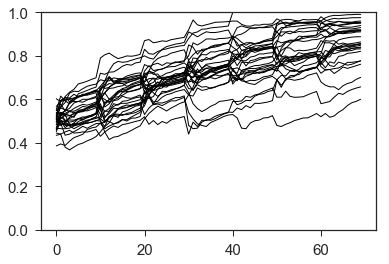

In [100]:
x = simulation(s=0.03, N=1e5, tmax=7*10, reps=30)
plt.plot(x, color='k', lw=1)
plt.ylim(0, 1);

In [195]:
N = 1e8
tmax = 7*5
reps = 96//2
ss = np.logspace(-3, -1, 50)
xs = np.array([simulation(s=s, N=N, tmax=tmax, reps=reps) for s in ss])

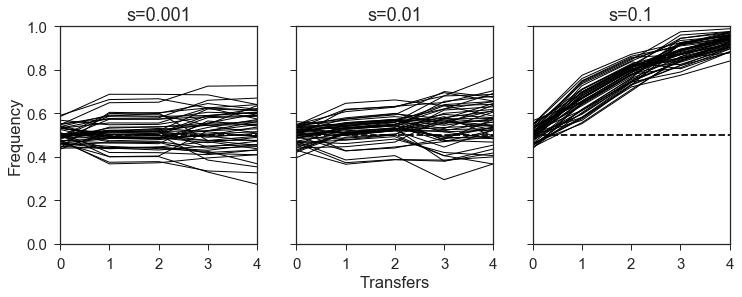

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for s, x, ax in zip([ss[0], ss[25], ss[-1]], [xs[0], xs[25], xs[-1]], axes):
    ax.plot(x[::7], color='k', lw=1)
    ax.set_title("s={:.2g}".format(s))
    ax.axhline(0.5, ls='--', color='k')
axes[0].set(
    ylabel=('Frequency'),
    ylim=(0, 1),
    xlim=(0, tmax/7-1)
)
axes[1].set_xlabel('Transfers');

In [197]:
def binomial_test(z, th=0.5, alpha=0.05):    
    return scipy.stats.binom_test(
        [(z > th).sum(), (z < 1-th).sum()], 
        p=0.5, alternative='greater') < alpha

In [198]:
ths = np.linspace(0.5, 1.0, 50)
binom_rejection = np.array([[binomial_test(x, th) for x in xs] for th in ths])

In [199]:
import betareg

def beta_test(Y, alpha=0.05):
    Y = Y[-1]
    Y = (Y * (Y.size - 1) + 0.5) / Y.size
    X = np.ones_like(Y)
    beta_model = betareg.Beta(Y, X)
    results = beta_model.fit()
#     print(results.params[0], results.conf_int(alpha)[0])
    return (results.conf_int(alpha)[0] > 0).all()
#     return results.pvalues[0] < alpha

In [200]:
beta_rejection = np.array([beta_test(x) for x in xs])

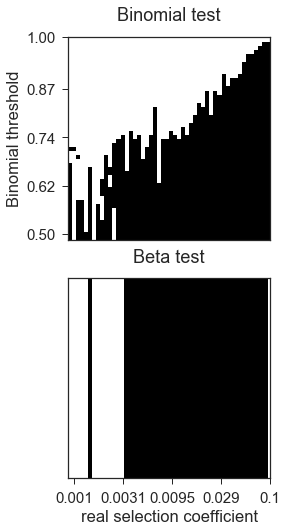

In [201]:
fig, axes = plt.subplots(2, 1, figsize=(4, 8))
cmap = mpl.colors.ListedColormap(['w', 'k'])
axes[0].matshow(binom_rejection, origin=(0,0), vmin=0, vmax=1, cmap=cmap)
axes[0].set(xlabel='', xticks=[], title='Binomial test',
            yticks=np.linspace(1, 50, 5, dtype=int), 
            yticklabels=['{:.2f}'.format(th) for th in ths[np.linspace(1, 50, 5, dtype=int)-1]],
            ylabel='Binomial threshold')
axes[1].matshow([beta_rejection], origin=(0,0), vmin=0, vmax=1, cmap=cmap)
axes[1].set(xlabel='real selection coefficient', ylabel='', title='Beta test',
            xticks=np.linspace(1, 50, 5), 
            xticklabels=[
                '{:.2g}'.format(s) for s in ss[np.linspace(1, 50, 5, dtype=int)-1]
            ],
            yticks=[], aspect=50)
axes[1].get_xaxis().set_ticks_position('bottom')
fig.tight_layout(h_pad=-1)


In [213]:
def intercept_to_s(intercept, t):
    return np.exp(intercept / t) - 1

def beta_estimate(Y, t, alpha=0.05):
    Y = Y[-1]
    Y = (Y * (Y.size - 1) + 0.5) / Y.size
    X = np.ones_like(Y)
    beta_model = betareg.Beta(Y, X)
    results = beta_model.fit()
    s = intercept_to_s(results.params[0], t)
    ci_low, ci_high = results.conf_int(alpha)[0]
    ci_low = intercept_to_s(ci_low, t)
    ci_high = intercept_to_s(ci_high, t)
    return dict(s=s, ci_low=ci_low, ci_high=ci_high)

In [214]:
s_estimates = pd.DataFrame([beta_estimate(x, tmax) for x in xs])
s_estimates.head()

,ci_high,ci_low,s
0,0.005570,-0.000333,0.002614
1,0.000848,-0.004901,-0.002031
2,0.004944,-0.001559,0.001687
3,0.004396,-0.001114,0.001637
4,0.003759,-0.003279,0.000234


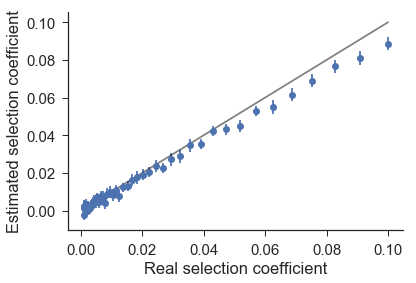

In [218]:
plt.errorbar(
    ss, s_estimates['s'], 
    yerr=(s_estimates['s']-s_estimates['ci_low'], s_estimates['ci_high']-s_estimates['s']),
    ls='',
    marker='o'
)
# plt.xscale('log')
# plt.yscale('log')
plt.plot(ss, ss, ls='-', color='k', alpha=0.5)
plt.xlabel('Real selection coefficient')
plt.ylabel('Estimated selection coefficient')
sns.despine()